# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

Load the scikit-learn modules we need:

In [2]:
from sklearn import neighbors, mixture

## Load Data

In [3]:
from mls import locate_data

In [4]:
cluster_data = pd.read_hdf(locate_data('cluster_d_data.hf5'))

In [5]:
blobs_data = pd.read_hdf(locate_data('blobs_data.hf5'))
blobs_targets = pd.read_hdf(locate_data('blobs_targets.hf5'))

Let's examine this new (N,D) = (2000,3) dataset using a `pairplot` with each sample colored to show the underlying generative model, consisting of three overlapping Gaussian blobs:

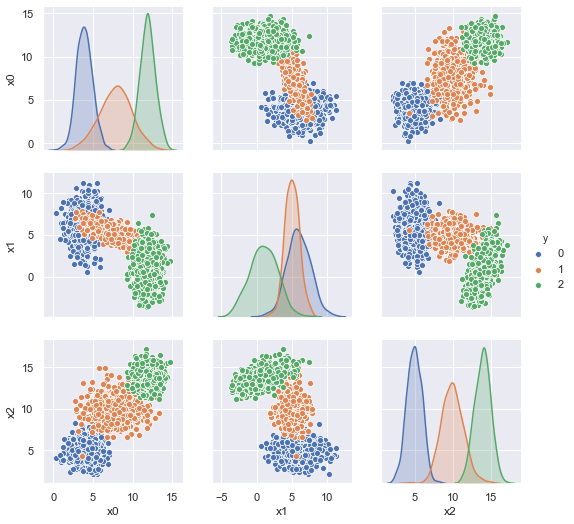

In [6]:
def plot_blobs(labels):
    Xy = blobs_data.copy()
    Xy['y'] = labels
    sns.pairplot(Xy, vars=('x0', 'x1', 'x2'), hue='y')
    
plot_blobs(labels=blobs_targets['y'])

## From Histograms to Kernel Density Estimates

We will start with 1D examples, so drop the other 2 columns:

In [7]:
blobs1d = blobs_data.drop(columns=['x1', 'x2'])

A histogram is a useful visualization of the 1D distribution of a feature. However, here we are after something more quantitative: a **density estimate**.  The underlying assumption of density estimation is that our data $X$ is a random sampling of some underlying continuous probability density function $P(x)$,
$$
X \sim P(x) \; .
$$
The task of **density estimation** is then to empirically estimate $P(x)$ from the observed $X$. This will always be an error prone process since, generally, $P(x)$ contains infinitely more information than the finite $X$ that we cannot hope to recover. Our goal is therefore to do the best possible job with the limited information available.

A histogram usually counts the number $n_i$ of samples falling into each of its $B$ predefined bins $b_{i-1} \le x \lt b_i$ (note that there are $B$ counts $n_i$ and $B+1$ bin edges $b_i$). This convention has the advantage that the error on each bin value is described by the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), which becomes indistinguishable from the [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) for large counts $n_i$, leading to the rule of thumb $n_i \pm \sqrt{n_i}$.

**EXERCISE:** A measurement pipeline often converts a raw count (of photons, electrons, etc) to a more convenient quantity. For example, suppose we count $n$ photons with a detector that is only 50% efficient, and then quote the number of photons that would be detected with perfect efficiency.  What is the resulting value and its uncertainty?

**ANSWER:** The corrected value is $2 n$ and its uncertainty is $2 \sqrt{n}$. Note that the detector inefficiency increases the error by a factor of $\sqrt{2}$ relative to a perfect detector (which would have an error of $\sqrt{2 n}$).

In order to estimate probability density, we convert each bin count $n_i$ into a corresponding density
$$
\rho_i = \frac{n_i}{N \left(b_i - b_{i-1}\right)}
$$
where $$
N = \sum_{i=1}^B n_i
$$
is the usual total number of samples, so that
$$
\sum_{i=1}^B \rho_i (b_i - b_{i-1}) \simeq \int \rho(x)\,dx = 1 \; .
$$
Use `density=True` with `plt.hist` or `norm_hist=True` with `sns.distplot` to request this convention.

Histogram bins are often equally spaced,
$$
b_i = x_{\min} + (x_{\max} - x_{\min}) \frac{i}{B} \quad , \quad i = 0, 1, \ldots, B \; .
$$
However, this is not necessary and non-uniform binning (e.g., logarithmic spacing) can be more effective when sample density varies significantly. (What is the best way to display a histogram with non-uniform bins?)

We will use the following function to compare histograms with other density estimators (as usual, you can ignore the details):

In [8]:
def estimate_density1d(X, limits=(0, 15), bins=15, kernels=None):
    # Prepare the fixed binning to use.
    bins = np.linspace(*limits, bins + 1) if bins else None
    # Plot a conventional histogram.
    sns.distplot(X, rug=(len(X) < 50), kde=False, bins=bins,
                 norm_hist=True, rug_kws=dict(lw=4), label='hist')
    if kernels:
        # Calculate and plot a KDE with bandwidth = binsize/2.
        bw = 0.5 * (bins[1] - bins[0])
        x_smooth = np.linspace(*limits, 500)
        for kernel in kernels.split(','):
            fit = neighbors.KernelDensity(kernel=kernel, bandwidth=bw).fit(X)
            y_smooth = np.exp(fit.score_samples(x_smooth.reshape(-1, 1)))
            plt.plot(x_smooth, y_smooth, label=kernel)
    plt.xlim(*limits)
    plt.ylabel('Probability density')
    plt.legend(fontsize='large')

Let's first compare histograms of very small samples (by restricting the rows of `blobs1d`). Note how the bin locations $b_i$ are predefined, independently of the data.

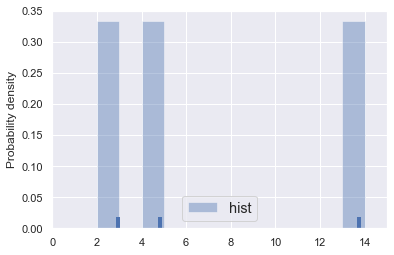

In [9]:
estimate_density1d(blobs1d.iloc[:3])

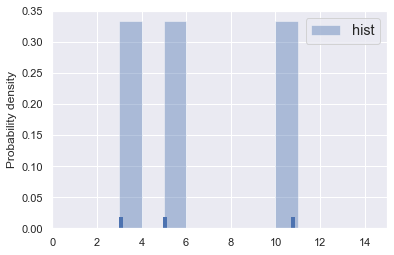

In [10]:
estimate_density1d(blobs1d.iloc[3:6])

These histogram density estimates are not very useful because we have chosen fixed bins that are too small for so few samples.  As an alternative, we can use the data to determine the binning, e.g. with the [Freedman-Diaconnis rule](https://en.wikipedia.org/wiki/Freedman-Diaconis_rule) that `sns.distplot` uses when `bins=None`:

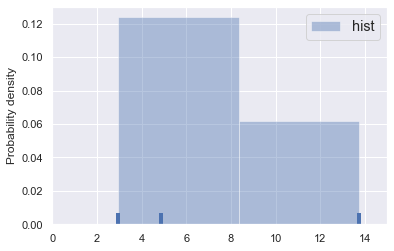

In [11]:
estimate_density1d(blobs1d.iloc[:3], bins=None)

This is an improvement, but an even better use of the data is to center the contribution of each sample on the sample itself, which is the key idea of **kernel density estimation**:

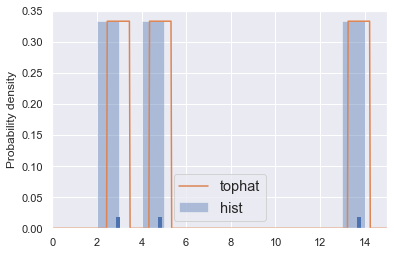

In [12]:
estimate_density1d(blobs1d.iloc[:3], kernels='tophat')

There is nothing special about the "tophat" shape assigned to each sample, which we call the **kernel**, and other choices are equally valid, e.g.

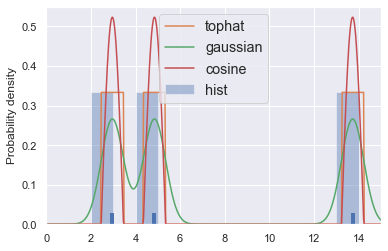

In [13]:
estimate_density1d(blobs1d.iloc[:3], kernels='tophat,gaussian,cosine')

Your choice of kernel effectively makes an a-priori assumption about the solution to the density estimation problem, thus allowing us to solve a problem that would otherwise be under-determined.  This general strategy is known as **regularization** and appears (in different forms) in many machine learning methods.

**NOTE:** this **kernel** is not the same as the **kernel functions** covered in the [nonlinear notebook](Nonlinear.ipynb):
 - **kernel:** centered function used to "spreads" each sample for a density estimate.
 - **kernel function:** similarity measure used to efficiently compute dot products in a higher-dimensional space.

With more samples, the individual kernels blend together and the results are less sensitive to the choice of kernel (and agree better with a histogram):

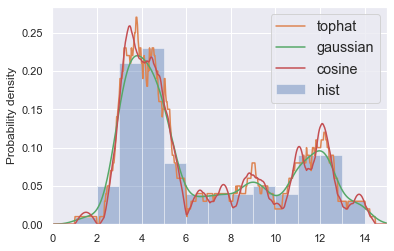

In [14]:
estimate_density1d(blobs1d.iloc[:100], kernels='tophat,gaussian,cosine')

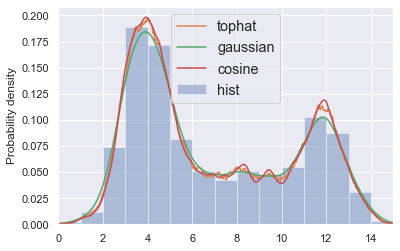

In [15]:
estimate_density1d(blobs1d.iloc[:2000], kernels='tophat,gaussian,cosine')

The [sklearn implementation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html) of [kernel density estimation (KDE)](https://en.wikipedia.org/wiki/Kernel_density_estimation) uses the familiar calling pattern, with two significant hyperparameters:

In [16]:
fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=1.0).fit(blobs1d)

Refer to the implementation of `estimate_density` above for details on how to calculate and plot the estimated smooth $P(x)$ from the resulting `fit` object.

Compare KDE of 3 samples with bandwidths of 1 and 2. Note that the spreading of each sample is always normalized, so doubling the width halves the height.

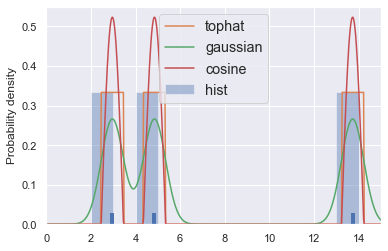

In [17]:
estimate_density1d(blobs1d.iloc[:3], kernels='tophat,gaussian,cosine')

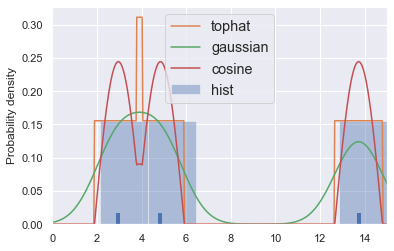

In [18]:
estimate_density1d(blobs1d.iloc[:3], kernels='tophat,gaussian,cosine', bins=7)

**DISCUSS:** How should the bandwidth be tuned, if at all, to account for:
- A doubling of the number of samples.
- A different underlying probability density $P(x)$.

The purpose of the kernel is to spread each sample to fill in the gaps due to finite data. In other words, we are estimating what we would expect to measure with an infinite dataset. With this picture, the bandwidth should be related to the mean gap size, which should ~halve when the sample size is doubled.

Just knowing that the probability density has changed does not provide any guidance on how to change the bandwidth. However, we might also know *how* it has changed by looking at the data.  For example, if the data appears much smoother, then increasing the bandwidth would be justified. Conversely, data with sharp edges or narrow peaks would benefit from a smaller bandwidth to preserve those features.

For further reading about histograms and KDE for 1D data, see [this blog post](https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html).

## Multidimensional KDE

KDE is not limited to 1D and we can replace our centered 1D kernels with centered multi-dimensional blobs to the estimate the underlying probability density $P(\vec{x})$ of any data.

If you just want to *see* a KDE of your data, without needing to do any calculations with it, a seaborn [kdeplot]() is the easiest solution for 1D and 2D, e.g.

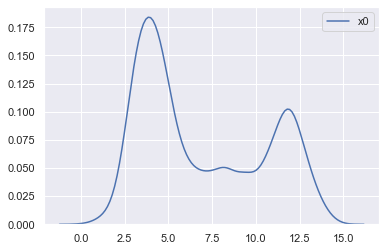

In [19]:
sns.kdeplot(blobs_data['x0'], kernel='gau', bw=0.5);

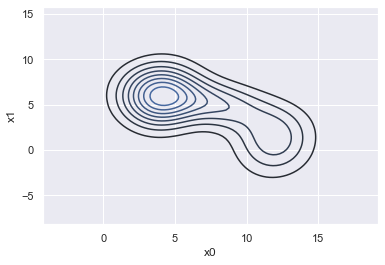

In [20]:
sns.kdeplot(blobs_data['x0'], blobs_data['x1'], kernel='gau', bw=1.5);

The `sns.displot` and `sns.jointplot` visualizations can also superimpose a KDE in 1D and 2D, although with less convenient control of the hyperparameters, e.g.

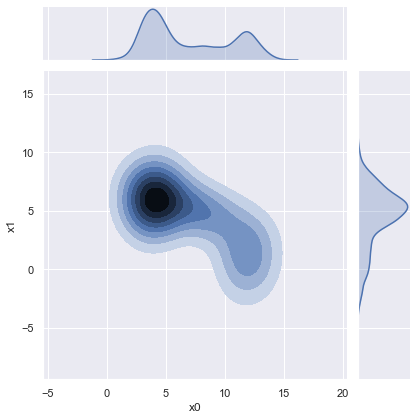

In [21]:
sns.jointplot('x0', 'x1', blobs_data, kind='kde',
              joint_kws=dict(kernel='gau', bw=1.5, shade_lowest=False),
              marginal_kws=dict(kernel='gau', bw=0.5));

For more quantitative applications, first run a `KernelDensity` fit with the usual calling convention:

In [22]:
fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data)

You can then either evaluate the fit an any arbitrary points in the sample space, e.g.

In [23]:
np.exp(fit.score_samples([[5, 5, 5], [10, 5, 10], [10, 10, 10]]))

array([0.00495426, 0.00244693, 0.        ])

Note that `score_samples()` returns $\log P(x)$, which provides better dynamic range in a fixed-size floating point number, so should be wrapped in `np.exp()` to recover $P(x)$.

Alternatively, you can generate random samples from the estimated $P(x)$ using, e.g.

In [24]:
gen = np.random.RandomState(seed=123)
fit.sample(n_samples=5, random_state=gen)

array([[ 4.94902631,  7.41065346, 10.97821932],
       [ 3.87363289,  3.80451607,  4.50283055],
       [11.09145063,  1.00812938, 13.29987882],
       [10.59026763,  2.55629527, 14.14410438],
       [ 8.9555949 ,  5.35446964,  8.37578739]])

This second option is useful as a building block for a Monte Carlo simulation or integration.

When going beyond 1D KDE, a single bandwidth hyperparameter is not sufficient since it assumes that the gaps between samples are both:
 - isotropic, i.e., the same in all directions, and
 - homogeneous, i.e., the same at all locations in the sample space.
 
Neither of these is generally true, as we can see from a 2D scatter plot of 100 samples:

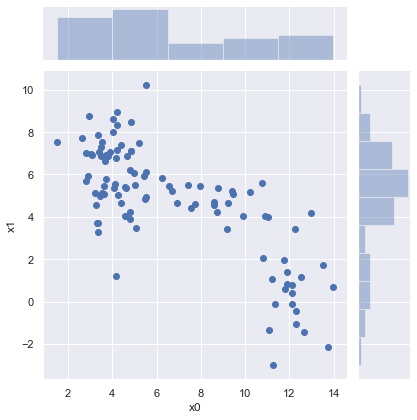

In [25]:
sns.jointplot('x0', 'x1', blobs_data.iloc[:100], kind='scatter');

The most general Gaussian kernel would have $D(D+1)/2$ shape parameters (covariance matrix elements) that vary slowly over the $N$-dimensional parameter space, instead of a single `bandwidth` parameter.

There are more sophisticated implementations of KDE that use the data itself to estimate kernels that are neither isotropic or homogeneous, e.g., in the [statsmodels package](http://www.statsmodels.org/devel/generated/statsmodels.nonparametric.kernel_density.KDEMultivariate.html). For an in-depth comparison of sklearn KDE with other python implementations, see [this blog post](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/).

However, there is no magic in KDE and the problem is fundamentally under-determined, so using simpler methods whose limitations are easier to understand is often preferable.  The best way to improve any density estimate is always to add more data!

## Gaussian Mixture Models

The KDE approach is often described as *non-parametric* since the fit is driven by the data without any free parameters of a goal function. Next, we will constrast KDE with **Gaussian mixture models (GMM)** which have many free parameters.

*SIDE NOTE: I don't find the "non-parametric" distinction very meaningful since any useful method always has significant hyperparameters.*

GMM assumes the following parametric form for the probability density:
$$
P(\vec{x}) = \sum_{k=1}^{K}\, \omega_k G(\vec{x} ; \vec{\mu}_k, C_k)
$$
where $G$ is a normalized $D$-dimensional Gaussian (normal) distribution:
$$
G(\vec{x} ; \vec{\mu}, C) = \left(2\pi\right)^{-D/2}\,\left| C\right|^{-1/2}\,
\exp\left[  -\frac{1}{2} \left(\vec{x} - \vec{\mu}\right)^T C^{-1} \left(\vec{x} - \vec{\mu}\right) \right]
$$
and the weights $\omega_k$ are normalized:
$$
\sum_{k=1}^K\, \omega_k = 1 \; .
$$
Note that this compact formula glosses over a lot of details:
- Notation: determinant $|C|$, inverse $C^{-1}$, transpose $\left(\vec{x} - \vec{\mu}\right)^T$.
- The object $C$ is a $D\times D$ covariance matrix that must be positive definite (and hence invertible).
- The argument of the exponential is a scalar computed from a vector-matrix expression.

**DISCUSS:** How many independent parameters are there when fitting the density of $N\times D$ data to $K$ Gaussians?

Each mean vector $\vec{\mu}_k$ has $D$ independent parameters.  Each covariance matrix $C_k$ has $D(D+1)/2$ independent parameters, due to the positive definite requirement, which implies $C^T = C$.  Finally, the $K$ weights $\omega_k$ only contribute $K-1$ independent parameters because they sum to one.

Therefore the total number of independent parameters for $K$ Gaussians is:
$$
(K - 1) + K D + K \frac{D(D+1)}{2} \; .
$$
For example, `blobs_data` has $D=3$ and $K=3$ leading to 29 parameters. Note that the number of parameters does not depend on the number of samples $N$, but our ability to accurately estimate all of these parameters certainly will.

GMM is another example of a machine-learning algorithm that can be efficiently solved with the Expectation-Maximization (EM) technique.  The [sklearn implementation](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) uses the familiar calling pattern with the number of designed components $K$ as its main hyperparameter:

In [26]:
fit = mixture.GaussianMixture(n_components=3).fit(blobs_data)

As with KDE, we have two options for using the resulting density estimate:

In [27]:
np.exp(fit.score_samples([[5, 5, 5], [10, 5, 10], [10, 10, 10]]))

array([8.91534159e-03, 2.43144309e-03, 2.90695614e-17])

In [28]:
fit.random_state = np.random.RandomState(seed=1)
fit.sample(n_samples=5)

(array([[ 3.35920221,  6.8992151 ,  6.23358241],
        [ 5.28533637,  9.77821911,  3.46514107],
        [ 4.33487451,  5.45480832,  6.40348508],
        [11.67026099,  5.06293373, 15.01944708],
        [ 5.59172048,  6.00763012,  8.64144266]]), array([0, 0, 0, 1, 2]))

Note that `fit.sample()` does not allow you to pass in your random state directly, which I consider a [bug](https://github.com/scikit-learn/scikit-learn/issues/10539), and returns true labels (0,1,2) for the generated samples in addition to the samples themselves.

**EXERCISE:** Perform a 3-component 1D GMM fit to `blobs1d` and make a plot to compare your GMM fit with a KDE fit to the same data (using a Gaussian kernel with bandwidth of 0.5). Hint: refer to `estimate_density1d` above.

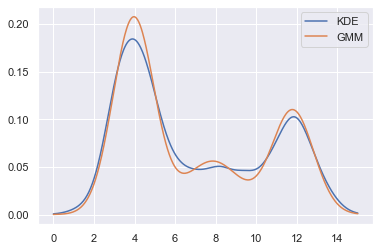

In [29]:
# Use the same fine grid of x values to calculate P(x) on.
x = np.linspace(0, 15, 500)
# Calcuate the KDE estimate of P(x)
kde_fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.5).fit(blobs1d)
y_kde = np.exp(kde_fit.score_samples(x.reshape(-1, 1)))
# Calculate the GMM estimate of P(x)
gmm_fit = mixture.GaussianMixture(n_components=3).fit(blobs1d)
y_gmm = np.exp(gmm_fit.score_samples(x.reshape(-1, 1)))
# Plot the results.
plt.plot(x, y_kde, label='KDE')
plt.plot(x, y_gmm, label='GMM')
plt.legend()

In [30]:
# Add your solution here...

Sometimes the individual $\alpha_i$, $\mu_i$ and $C_i$ parameters of each fitted component are useful.  For example, the parameters of the earlier 3D GMM fit are (do the shapes of each array make sense?):

In [31]:
print(np.round(fit.weights_, 3))
print(np.round(fit.means_, 3))
print(np.round(fit.covariances_, 3))

[0.501 0.25  0.249]
[[ 3.928  5.98   4.992]
 [11.918  1.013 13.981]
 [ 7.916  5.033 10.016]]
[[[ 1.028e+00  4.800e-02 -2.700e-02]
  [ 4.800e-02  2.805e+00 -2.600e-02]
  [-2.700e-02 -2.600e-02  9.880e-01]]

 [[ 9.260e-01  9.000e-02 -2.000e-03]
  [ 9.000e-02  3.758e+00  9.890e-01]
  [-2.000e-03  9.890e-01  1.072e+00]]

 [[ 3.871e+00 -1.511e+00 -2.020e-01]
  [-1.511e+00  1.027e+00 -4.000e-03]
  [-2.020e-01 -4.000e-03  1.992e+00]]]


The following wrapper uses `GMM_pairplot` to show a grid of all 2D projections that compare the data scatter with the fit components. The transparency of each component indicates its relative weight.  The wrapper also prints some numbers that we will discuss soon.

In [32]:
from mls import GMM_pairplot

def GMM_fit(data, n_components, entropy=False):
    fit = mixture.GaussianMixture(n_components=n_components).fit(data)
    print('AIC = {:.3f}, BIC = {:.3f}'.format(fit.aic(data), fit.bic(data)))
    GMM_pairplot(data, fit.weights_, fit.means_, fit.covariances_, entropy=entropy)

AIC = 23357.804, BIC = 23520.230


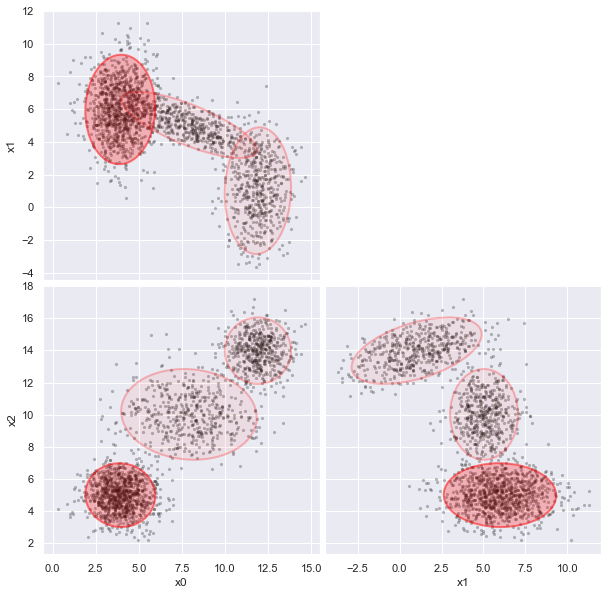

In [33]:
GMM_fit(blobs_data, 3)

Use `entropy=True` for an alternative visualization where points are colored according to how confidently they can be assigned to a single Gaussian component, with darker colors to indicate the most ambiguous samples. We use [entropy](https://en.wikipedia.org/wiki/Entropy_\(information_theory\)) as the measure of ambiguity.

(Why are only some of the points in the overlap regions considered ambiguous?)

AIC = 23357.804, BIC = 23520.230


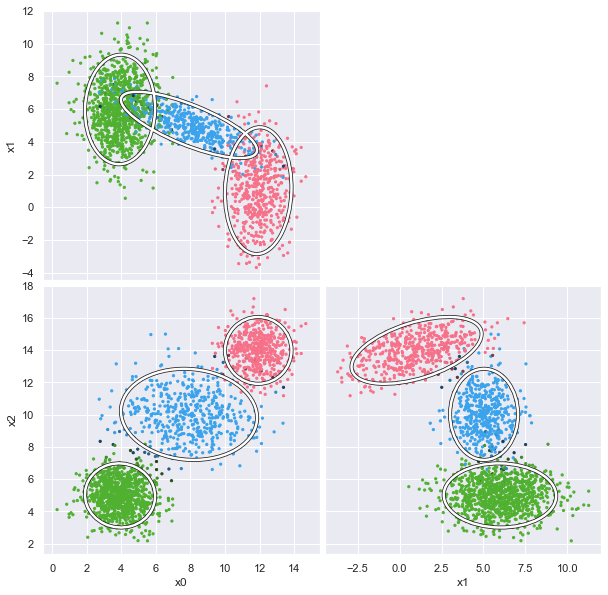

In [34]:
GMM_fit(blobs_data, 3, entropy=True)

Although GMM is primarily a density estimator, a GMM fit can also be used for clustering, with the advantage that we can calculate the relative probability of cluster membership for borderline samples. However, some care is required to interpret GMM for clustering since, unlike other clustering methods, GMM components can be highly overlapping and a single "visual cluster" is often fit with multiple Gaussians.

**EXERCISE:** Fit the `cluster_data` loaded above using `GMM_fit()`. Try different numbers of components to get a reasonable fit by eye. How do the printed values of AIC and BIC track the visual "goodness of fit"?

Since the visual clusters in the data are symmetric, the number of components $K$ should be even, allowing $K/2$ per cluster. The results look reasonable starting with $K = 8$ with a small improvement at $K = 10$, but no further improvement at larger $K$. Fits start to look worse at $K = 14$ as they latch onto noise fluctuations in the randomly generated samples.

AIC = 3172.444, BIC = 3421.106


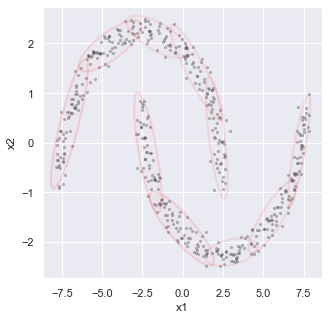

In [35]:
GMM_fit(cluster_data, 10)

The [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) and [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) are different measures of the "goodness of fit" of the GMM to the data.  They both reward small residuals while penalizing extra fit parameters, to provide guidance on how many components to use.  However, both methods are ad-hoc and you should prefer the (more expensive) model selection methods we will see later whenever the answer really matters.

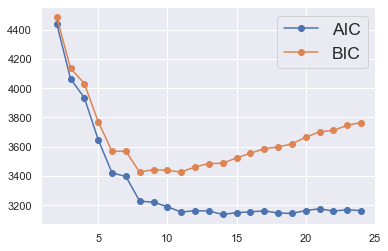

In [36]:
def plot_aic_bic(data, n_components=range(2, 25)):
    aic, bic = [], []
    for n in n_components:
        fit = mixture.GaussianMixture(n_components=n).fit(data)
        aic.append(fit.aic(data))
        bic.append(fit.bic(data))
    plt.plot(n_components, aic, '-o', label='AIC')
    plt.plot(n_components, bic, '-o', label='BIC')
    plt.legend(fontsize='x-large')
    
plot_aic_bic(cluster_data)

In [37]:
# Add your solution here...

GMM is closely related to two other algorithms we have already encountered, KMeans and FactorAnalysis:
- All three use the versatile Expectation-Maximization (EM) method to achieve robust convergence.
- KMeans is a special case of GMM where each component's $C$ is reduced to a single parameter $\sigma$, via $C = \sigma^2 I$, and cluster membership weights are binary (0 or 1) rather than continuous (0-1).
- GMM implementations typically use KMeans to obtain its initial parameter values, before EM iterations.
- FactorAnalysis is an adaption of GMM with a single component for cases where the number of samples $N$ is insufficient to estimate the $D(D+1)/2$ indepdent elements of a full covariance matrix, so instead we assume a simpler (but non-diagonal) covariance with $N(D + 1)$ independent parameters.

## Extreme Deconvolution

A variation of GMM that is popular in astronomy is called "extreme deconvolution" (though it is not really either of these).  The original paper is [Bovy 2009](https://arxiv.org/abs/0905.2979) and the method is implemented [here](http://www.astroml.org/modules/generated/astroML.density_estimation.XDGMM.html) and [here](https://github.com/jobovy/extreme-deconvolution).

XD is a generalization of GMM to cases where each sample has an associated Gaussian uncertainty in its feature values, and we wish to estimate what the density would be without any errors.

In the simplest case, all samples have the same uncertainty, so we just need to subtract this uncertainty (in quadrature) from the covariance assigned to each GMM component.  XD can also handle the most interesting case where each sample has a different (but still Gaussian) uncertainty.